Semantic Segmentation 
============

In this exercise you are going to work on a computer vision task called semantic segmentation. In comparison to image classification the goal is not to classify an entire image but each of its pixels separately. This implies that the  output of the network is not a single scalar but a segmentation with the same shape as the input image. Think about why you should rather use convolutional than fully-connected layers for this task!

<img src="https://camo.githubusercontent.com/d10b897e15344334e449104a824aff6c29125dc2/687474703a2f2f63616c76696e2e696e662e65642e61632e756b2f77702d636f6e74656e742f75706c6f6164732f646174612f636f636f7374756666646174617365742f636f636f73747566662d6578616d706c65732e706e67">

# 1. Preparation

## Imports

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

from exercise_code.data.segmentation_dataset import SegmentationData, label_img_to_rgb
from exercise_code.data.download_utils import download_dataset
from exercise_code.util import visualizer, save_model
from exercise_code.util.Util import checkSize, checkParams, test
from exercise_code.networks.segmentation_nn import SegmentationNN, DummySegmentationModel
from exercise_code.tests import test_seg_nn
#set up default cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and Visualize Data

#### MSRC-v2 Segmentation Dataset

The MSRC v2 dataset is an extension of the MSRC v1 dataset from Microsoft Research in Cambridge. It contains *591* images and *23* object classes with accurate pixel-wise labeled images. 



The image ids are stored in the txt file `train.txt`, `val.txt`, `test.txt`. The dataloader will read the image id in the txt file and fetch the corresponding input and target images from the image folder. 
<img src='images/input_target.png'/>



As you can see in `exercise_code/data/segmentation_dataset.py`, each segmentation label has its corresponding RGB value stored in the `SEG_LABELS_LIST`. The label `void` means `unlabeled`, and it is displayed as black `"rgb_values": [0, 0, 0]` in the target image. The target image pixels will be labeled based on its color using `SEG_LABELS_LIST`.

```python
                SEG_LABELS_LIST = [
                {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
                {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
                {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
                {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
                {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
                {"id": 4,  "name": "horse",      "rgb_values": [128, 0,    128]},
                {"id": 5,  "name": "sheep",      "rgb_values": [0,   128,  128]},
                ...]    
```

<div class="alert alert-block alert-warning">
    <h3>Note: The label <code>void</code></h3>
    <p>Pixels with the label <code>void</code> should neither be considered in your loss nor in the accuracy of your segmentation. See implementation for details.</p>
</div>

In [37]:
download_url = 'http://i2dl.vc.in.tum.de/static/data/segmentation_data.zip'
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(i2dl_exercises_path, 'datasets','segmentation')


download_dataset(
    url=download_url,
    data_dir=data_root,
    dataset_zip_name='segmentation_data.zip',
    force_download=False,
)

train_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/train.txt')
val_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/val.txt')
test_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/test.txt')

If you want to implement data augmentation methods, make yourself familiar with the segmentation dataset and how we implemented the `SegmentationData` class in `exercise_code/data/segmentation_dataset.py`. Furthermore, you can check the original label description in `datasets/segmentation/segmentation_data/info.html`.

For now, let's look at a few samples of our training set:

Train size: 276
Validation size: 59
Img size:  torch.Size([3, 240, 240])
Segmentation size:  torch.Size([240, 240])


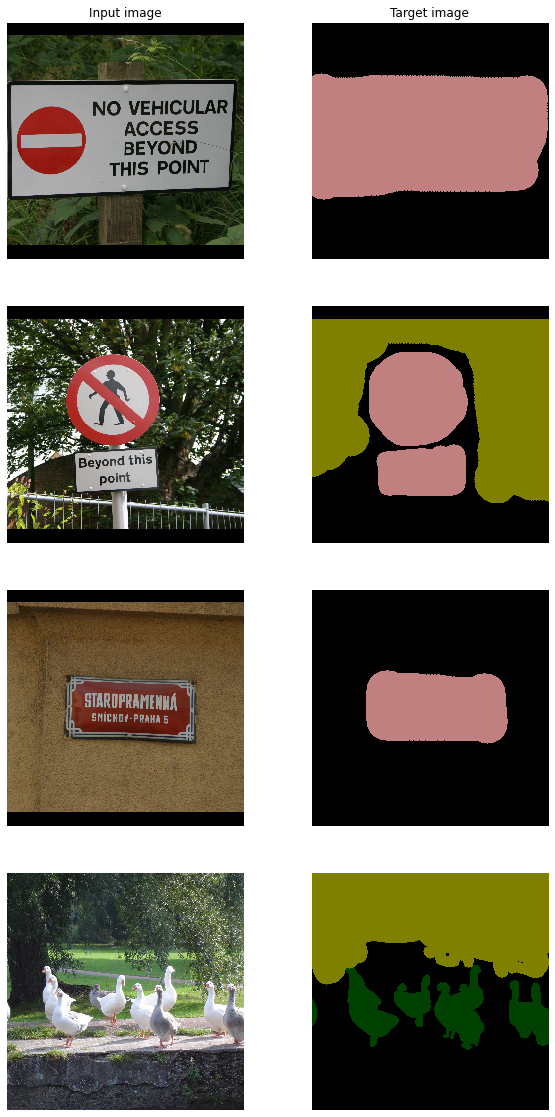

In [38]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 4
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    plt.imshow(label_img_to_rgb(target.numpy()))
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

We can already see that the dataset is quite small in comparison to our previous datasets, e.g., for CIFAR10 we had ten thousands of images while we only have 276 training images in this case. In addition, the task is much more difficult than a "simple 10 class classification", as we have to assign a label to each pixel! What's more, the images are much bigger as we are now considering images of size 240x240 instead of 32x32. 

That means that you shouldn't expect our networks to perform very well, so don't be too disappointed.

# 2. Semantic Segmentation 

## Dummy Model

In `exercise_code/networks/segmentation_nn.py` we define a naive `DummySegmentationModel`, which always predicts the scores of segmentation labels of the first image. Let's try it on a few images and visualize the outputs using the `visualizer` we provide. The `visualizer` takes in the model and dataset, and visualizes the first four (Input, Target, Prediction) pairs. 

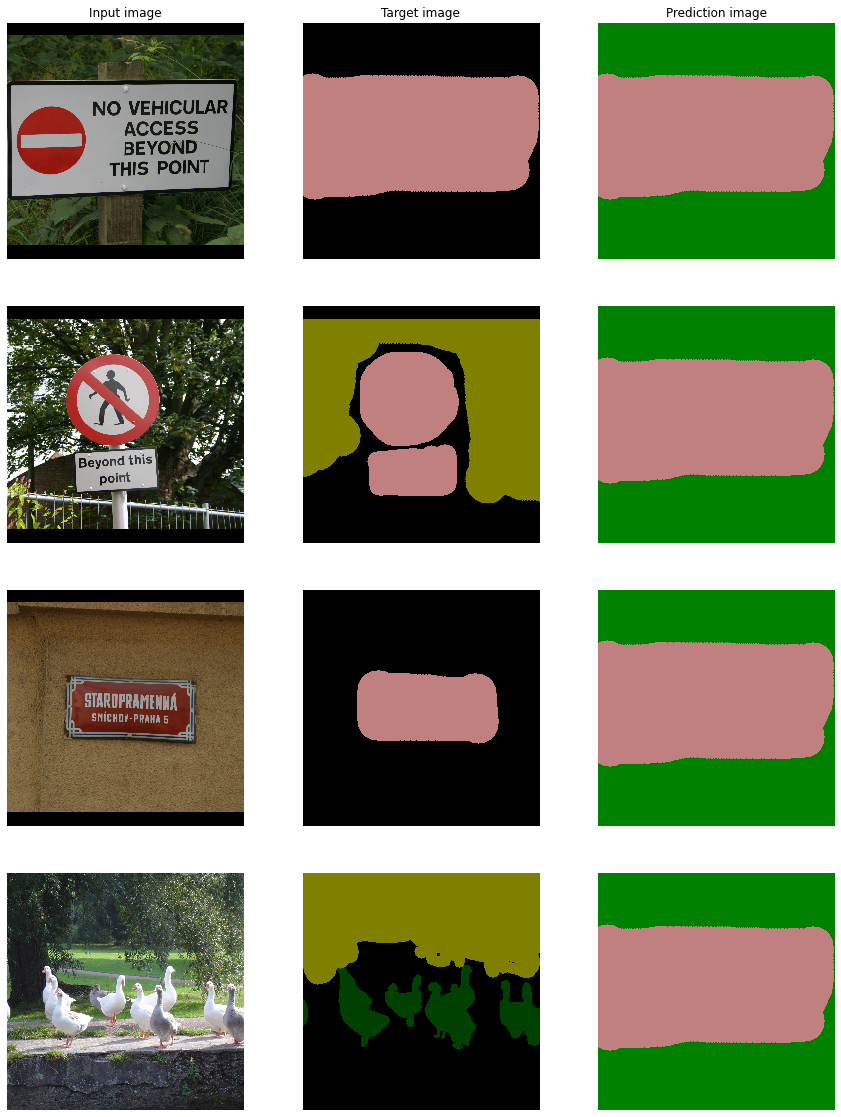

In [39]:
dummy_model = DummySegmentationModel(target_image=train_data[0][1])

# Visualization function
visualizer(dummy_model, train_data)

You can use the visualizer function in your training scenario to print out your model predictions on a regular basis.

## Loss and Metrics
The loss function for the task of image segmentation is a pixel-wise cross entropy loss. This loss examines each pixel individually, comparing the class predictions (depth-wise pixel vector) to our one-hot encoded target vector. 
<img src='images/loss_img.png' width=80% height=80%/>
source: https://www.jeremyjordan.me/semantic-segmentation/

Up until now we only used the default loss function (`nn.CrossEntropyLoss`) in our solvers. However, In order to ignore the `unlabeled` pixels for the computation of our loss, we have to use a customized version of the loss for the initialization of our segmentation solver. The `ignore_index` argument of the loss can be used to filter the `unlabeled` pixels and computes the loss only over remaining pixels.


In [40]:
loss_func = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction='mean')

for (inputs, targets) in train_data[0:4]:
    inputs, targets = inputs, targets
    outputs = dummy_model(inputs.unsqueeze(0))
    losses = loss_func(outputs, targets.unsqueeze(0))
    print(losses)

tensor(2.2072)
tensor(2.9416)
tensor(2.2076)
tensor(3.2083)


<div class="alert alert-warning">
    <h3>Note: Non-zero loss for the first sample</h3> 
    <p>The output of our dummy model is one-hot-coded tensor. Since there is <b>softmax</b> function in the <b>nn.CrossEntropyLoss</b> function, the loss is:  
    $$loss(x, class) = - \log \left( \frac{\exp(x[class])}{\Sigma_j \exp (x[j])} \right) = âˆ’x[class]+\log \left( \Sigma_j \exp(x[j]) \right)$$
     and the loss will not be zero.    </p>
<p>i.e. for $x=[0, 0, 0, 1],class=3$,$\quad$ the loss: 
$loss(x,class) = -1 +\log(\exp(0)+\exp(0)+\exp(0)+\exp(1)) = 0.7437$ </p>
</div>

To obtain an evaluation accuracy, we can simply compute the average per pixel accuracy of our network for a given image. We will use the following function:

In [41]:
def evaluate_model(model, dataloader):
    test_scores = []
    model.eval()
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model.forward(inputs)
        _, preds = torch.max(outputs, 1)
        targets_mask = targets >= 0
        test_scores.append(np.mean((preds.cpu() == targets.cpu())[targets_mask].numpy()))

    return np.mean(test_scores)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=False,num_workers=0)
print(evaluate_model(dummy_model, test_loader))

0.14179702232915609


You will see reasonably high numbers as your accuracy when you do the training later. The reason behind that is the fact that most output pixels are of a single class and the network can just overfit to common classes such as "grass".

## Step 1: Design your own model

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement your network architecture in <code>exercise_code/networks/segmentation_nn.py</code>. In this task, you will use pytorch to setup your model.
    </p>
</div>

To compensate for the dimension reduction of a typical convolution layer, you should probably include either a single `nn.Upsample` layer, use a combination of upsampling layers as well as convolutions or even transposed convolutions near the end of your network to get back to the target image shape.

This file is mostly empty but contains the expected class name, and the methods that your model needs to implement (only `forward()` basically). 
The only rules your model design has to follow are:
* Inherit from `torch.nn.Module` or `pytorch_lightning.LightningModule`
* Perform the forward pass in `forward()`. Input dimension is (N, C, H, W) and output dimension is (N, num_classes, H, W)
* Have less than 5 million parameters
* Have a model size of less than 50MB after saving

Furthermore, you need to pass all your hyperparameters to the model in a single dict `hparams`.

<div class="alert alert-warning">
    <h3>Note: Transfer learning</h3>
    <p>In this exercise, we encourage you to do transfer learning as we learned in exercise 8, since this will boost your model performance and save training time. You can import pretrained models from torchvision in your model and use its feature extractor (e.g. <code>alexnet.features</code>) to get the image feature. Feel free to choose more advanced pretrained model like ResNet, MobileNet for your architecture design.</p>       
</div>

See [here](https://pytorch.org/vision/stable/models.html) for more info of the torchvison pretrained models.


In [42]:
hparams = {
    # TODO: if you have any model arguments/hparams, define them here and read them from this dict inside SegmentationNN class
    "bilinear": True
}

In [43]:
model = SegmentationNN(hparams = hparams)
test_seg_nn(model)

ParamCountTest passed. Your model has 2.947 mio. params.
FileSizeTest passed. Your model is 11.9 MB large
All tests passed for your model. Tests passed: 2/2


## Step 2: Train your own model

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p> In addition to the network itself, you will also need to write the code for the model training. You can use PyTorch Lightning for that, or you can also write it yourself in standard PyTorch.
    </p>
</div>

In [56]:
model = SegmentationNN(hparams=hparams)
########################################################################
# TODO - Train Your Model                                              #
########################################################################

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=8, 
                                           shuffle=True)
# 定义优化算法
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08)
# 定义Loss算法
loss_func = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction='mean')
# best_loss统计，初始化为正无穷
best_loss = 1000000
# 训练epochs次
for epoch in range(50):
    # 训练模式
    model.train()
    # 按照batch_size开始训练
    for image, label in train_loader:
        optimizer.zero_grad()
#         # 将数据拷贝到device中
#         image = image.to(device=device, dtype=torch.float32)
#         label = label.to(device=device, dtype=torch.float32)
        # 使用网络参数，输出预测结果
        pred = model(image)
        # 计算loss
        loss = loss_func(pred, label)
        print('Loss/train', loss.item())
        # 保存loss值最小的网络参数
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), 'best_model.pth')
        # 更新参数
        loss.backward()
        optimizer.step()

#######################################################################
#                           END OF YOUR CODE                          #
#######################################################################

Loss/train 3.213200330734253
Loss/train 3.1244359016418457
Loss/train 3.2108256816864014
Loss/train 3.1727006435394287
Loss/train 3.2696056365966797
Loss/train 3.078972578048706
Loss/train 3.037320375442505
Loss/train 3.0617928504943848
Loss/train 3.1542725563049316
Loss/train 3.0974252223968506
Loss/train 3.0242209434509277
Loss/train 3.0546274185180664
Loss/train 2.943686008453369
Loss/train 3.142009735107422
Loss/train 3.058702230453491
Loss/train 2.9681243896484375
Loss/train 2.832388162612915
Loss/train 3.0152173042297363
Loss/train 2.9381160736083984
Loss/train 2.9509963989257812
Loss/train 2.99432635307312
Loss/train 2.8298118114471436
Loss/train 3.0401952266693115
Loss/train 2.9263646602630615
Loss/train 2.8736813068389893
Loss/train 2.861518383026123
Loss/train 2.7832953929901123
Loss/train 2.951230525970459
Loss/train 2.7658727169036865
Loss/train 2.7989745140075684
Loss/train 2.8420276641845703
Loss/train 2.9139034748077393
Loss/train 2.842046022415161
Loss/train 2.827452421

Loss/train 2.0828330516815186
Loss/train 2.609374523162842
Loss/train 2.255605697631836
Loss/train 2.261950731277466
Loss/train 1.943756103515625
Loss/train 2.143221139907837
Loss/train 2.229641914367676
Loss/train 2.0655605792999268
Loss/train 2.664970636367798
Loss/train 1.9565324783325195
Loss/train 2.2093968391418457
Loss/train 2.0537314414978027
Loss/train 2.2002058029174805
Loss/train 2.172107696533203
Loss/train 2.3909499645233154
Loss/train 1.903899908065796
Loss/train 2.4261648654937744
Loss/train 1.8059970140457153
Loss/train 2.351675033569336
Loss/train 1.9252448081970215
Loss/train 2.1739718914031982
Loss/train 1.954276442527771
Loss/train 1.9688009023666382
Loss/train 2.2978641986846924
Loss/train 2.0257856845855713
Loss/train 2.2578256130218506
Loss/train 1.9578226804733276
Loss/train 2.386442184448242
Loss/train 1.8862385749816895
Loss/train 2.3636858463287354
Loss/train 2.4393298625946045
Loss/train 2.1118457317352295
Loss/train 2.1543285846710205
Loss/train 2.285285472

Loss/train 1.4904361963272095
Loss/train 1.675795078277588
Loss/train 2.1901931762695312
Loss/train 2.0928142070770264
Loss/train 1.602166771888733
Loss/train 1.723928689956665
Loss/train 1.9721348285675049
Loss/train 1.8948445320129395
Loss/train 1.9322208166122437
Loss/train 1.7770458459854126
Loss/train 1.6851695775985718
Loss/train 1.9578922986984253
Loss/train 1.4929416179656982
Loss/train 1.6466436386108398
Loss/train 1.717877984046936
Loss/train 1.793214201927185
Loss/train 1.771165370941162
Loss/train 2.0053584575653076
Loss/train 1.585654377937317
Loss/train 1.7117208242416382
Loss/train 1.684244155883789
Loss/train 2.3382720947265625
Loss/train 1.9384514093399048
Loss/train 1.9892327785491943
Loss/train 1.721706509590149
Loss/train 1.544707179069519
Loss/train 1.3712350130081177
Loss/train 2.196028709411621
Loss/train 1.9679912328720093
Loss/train 1.911215901374817
Loss/train 1.9726580381393433
Loss/train 2.407881021499634
Loss/train 1.7336772680282593
Loss/train 1.5059137344

Loss/train 1.3454508781433105
Loss/train 1.5017311573028564
Loss/train 1.760479211807251
Loss/train 1.5847768783569336
Loss/train 1.6954126358032227
Loss/train 1.550806999206543
Loss/train 1.980068564414978
Loss/train 1.8021713495254517
Loss/train 1.5577384233474731
Loss/train 1.447759747505188
Loss/train 1.3796091079711914
Loss/train 1.978281021118164
Loss/train 1.7373822927474976
Loss/train 1.9243191480636597
Loss/train 1.7007185220718384
Loss/train 1.2137038707733154
Loss/train 1.5888651609420776
Loss/train 1.582722783088684
Loss/train 1.2219319343566895
Loss/train 1.2677056789398193
Loss/train 1.3135993480682373
Loss/train 1.4872026443481445
Loss/train 1.5884226560592651
Loss/train 1.2677710056304932
Loss/train 1.4355117082595825
Loss/train 1.7572078704833984
Loss/train 1.5044572353363037
Loss/train 1.15432608127594
Loss/train 1.4877183437347412
Loss/train 1.3066996335983276
Loss/train 1.7388951778411865
Loss/train 1.4643064737319946
Loss/train 1.6651674509048462
Loss/train 1.59490

Loss/train 1.3739995956420898
Loss/train 1.6609398126602173
Loss/train 0.9090004563331604
Loss/train 1.0718722343444824
Loss/train 1.4425066709518433
Loss/train 1.071045160293579
Loss/train 1.3500313758850098
Loss/train 1.1876038312911987
Loss/train 1.238837480545044
Loss/train 1.1716623306274414
Loss/train 1.1845191717147827
Loss/train 1.1700482368469238
Loss/train 1.914509892463684
Loss/train 1.2106077671051025
Loss/train 0.9673207402229309
Loss/train 1.3796113729476929
Loss/train 0.9871869087219238
Loss/train 1.373818278312683
Loss/train 1.0606958866119385
Loss/train 1.599805474281311
Loss/train 1.2523003816604614
Loss/train 1.3048499822616577
Loss/train 1.6502418518066406
Loss/train 1.4935849905014038
Loss/train 1.2592697143554688
Loss/train 1.0931131839752197
Loss/train 1.0759556293487549
Loss/train 1.3895519971847534
Loss/train 1.2606879472732544
Loss/train 1.218830943107605
Loss/train 1.1562798023223877
Loss/train 1.163543701171875
Loss/train 1.3193089962005615
Loss/train 1.4681

Loss/train 0.857696533203125
Loss/train 1.7856255769729614
Loss/train 1.268896222114563
Loss/train 0.8057427406311035
Loss/train 1.141357660293579
Loss/train 1.142914891242981
Loss/train 1.7112339735031128
Loss/train 1.07997465133667
Loss/train 1.4462785720825195
Loss/train 1.1806042194366455
Loss/train 1.3253036737442017
Loss/train 1.3481369018554688
Loss/train 1.1622546911239624
Loss/train 1.2130975723266602
Loss/train 1.481906533241272
Loss/train 1.448119044303894
Loss/train 1.5002529621124268
Loss/train 1.2401717901229858
Loss/train 1.276719331741333
Loss/train 1.2975369691848755
Loss/train 0.8558902740478516
Loss/train 1.0029385089874268
Loss/train 1.4494621753692627
Loss/train 1.0486795902252197
Loss/train 0.9450594186782837
Loss/train 1.0386133193969727
Loss/train 1.8904699087142944
Loss/train 1.0640616416931152
Loss/train 1.1166117191314697
Loss/train 1.1258071660995483
Loss/train 1.1749354600906372
Loss/train 1.4341379404067993
Loss/train 0.9652098417282104
Loss/train 1.296046

Loss/train 1.0058425664901733
Loss/train 1.015816330909729
Loss/train 0.9540771245956421
Loss/train 0.946874737739563
Loss/train 0.8640068769454956
Loss/train 1.0057399272918701
Loss/train 0.9033706188201904
Loss/train 0.8689230680465698
Loss/train 0.7201632857322693
Loss/train 2.162428617477417
Loss/train 1.1218618154525757
Loss/train 1.0666546821594238
Loss/train 0.6652806401252747
Loss/train 0.6944471001625061
Loss/train 0.8142459392547607
Loss/train 0.8906701803207397
Loss/train 1.2636229991912842
Loss/train 1.0342789888381958
Loss/train 0.6418507695198059
Loss/train 0.6925995945930481
Loss/train 1.1384224891662598
Loss/train 1.3497438430786133
Loss/train 0.8274210691452026
Loss/train 0.651066243648529
Loss/train 1.165077567100525
Loss/train 1.1438080072402954
Loss/train 0.8672946095466614
Loss/train 0.8327562212944031
Loss/train 0.8358287811279297
Loss/train 0.9308590292930603
Loss/train 0.8340417742729187
Loss/train 0.9500192999839783
Loss/train 0.6346274614334106
Loss/train 1.09

# 3. Test your Model

In [57]:
test(evaluate_model(model, test_loader))

Validation-Accuracy: 65.54044707190982%
Congrats! The accuracy passes the threshold, you can try to submit your model to server now.


# 4. Visualization

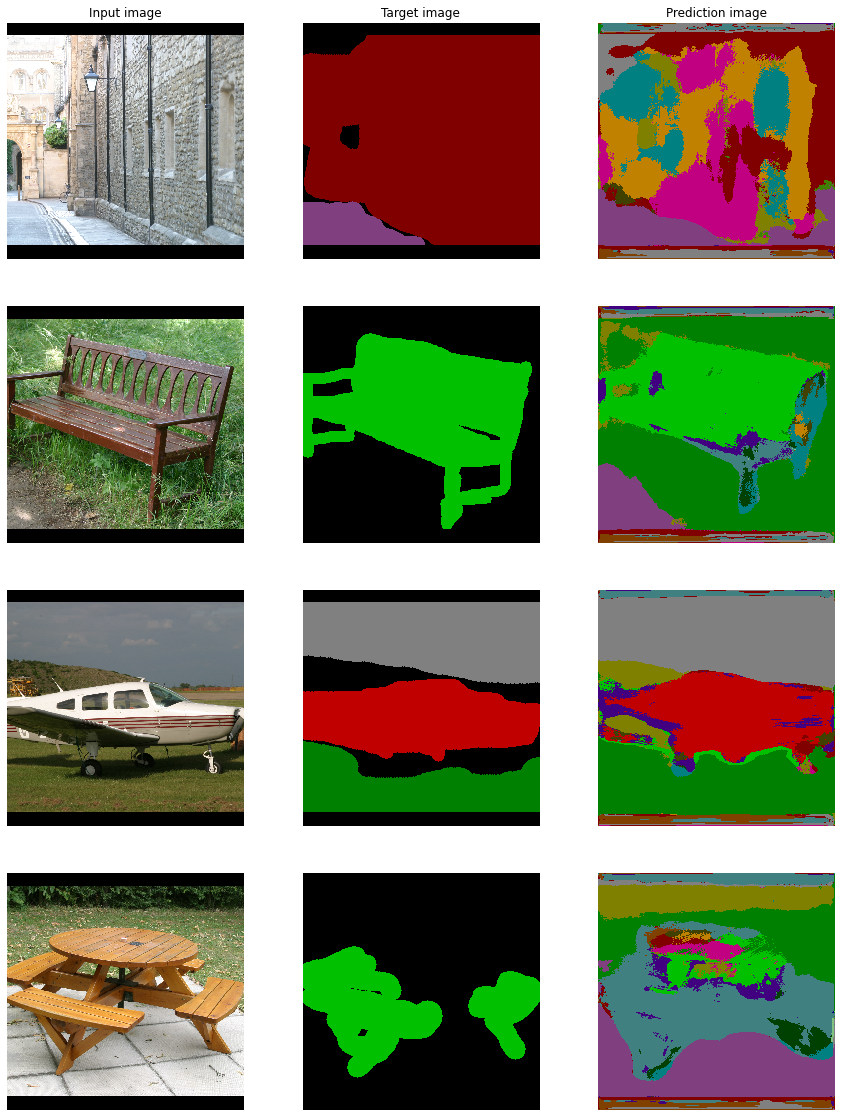

In [58]:
visualizer(model, test_data)

## Save the Model for Submission

When you are satisfied with your training, save the model for [submission](https://i2dl.vc.in.tum.de/submission/). In order to be eligible for the bonus points you have to achieve an accuracy above __60%__.

In [ ]:
os.makedirs('models', exist_ok=True)
save_model(model, "segmentation_nn.model")
checkSize(path = "./models/segmentation_nn.model")

In [ ]:
from exercise_code.util.submit import submit_exercise

submit_exercise('exercise10')


# Submission Goals

- Goal: Implement and train a convolutional neural network for Semantic Segmentation.
- Passing Criteria: Reach **Accuracy >= 64%** on __our__ test dataset. The submission system will show you your score after you submit.
- Submission start: __Friday, January 7, 2022 - 13:00__
- Submission deadline: __Thursday, January 13, 2022 - 15:59__
- You can make **$\infty$** submissions until the deadline. Your __best submission__ will be considered for bonus